# Mirroring fields

In certain situation it is beneficial to mirror fields. We show here one way of doing that

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pysemtools

In [2]:
from pysemtools.io.ppymech.neksuite import pynekread
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

### Transforming the domain

It is important to transform the domain in such a way that the axis/plane of symmetry is on the zero coordinate.

In [3]:
msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
pynekread('../data/mixlay0.f00001', comm, data_dtype=np.double, msh=msh, fld=fld)
coef = Coef(msh, comm, get_area=False)

# Move the mesh to be symmetric about the y-axis
max_y = np.max(msh.y)
min_y = np.min(msh.y)
msh.y = msh.y - (max_y - min_y)/2

2025-04-04 11:35:47,302 - Mesh - INFO - Initializing empty Mesh object.
2025-04-04 11:35:47,304 - Field - INFO - Initializing empty Field object
2025-04-04 11:35:47,305 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-04-04 11:35:47,311 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-04-04 11:35:47,312 - Mesh - INFO - Initializing common attributes.
2025-04-04 11:35:47,312 - Mesh - INFO - Getting vertices
2025-04-04 11:35:47,314 - Mesh - INFO - Getting edge centers
2025-04-04 11:35:47,319 - Mesh - INFO - Facet centers not available for 2D
2025-04-04 11:35:47,320 - Mesh - INFO - Creating connectivity
2025-04-04 11:35:47,678 - Mesh - INFO - Mesh object initialized.
2025-04-04 11:35:47,679 - Mesh - INFO - Mesh data is of type: float64
2025-04-04 11:35:47,680 - Mesh - INFO - Elapsed time: 0.36899283600000005s
2025-04-04 11:35:47,680 - pynekread - INFO - Reading field data
2025-04-04 11:35:47,685 - pynekread - INFO - File read
2025-04-04 11:35:47,686 - pynek

### Plot the 2D velocity field

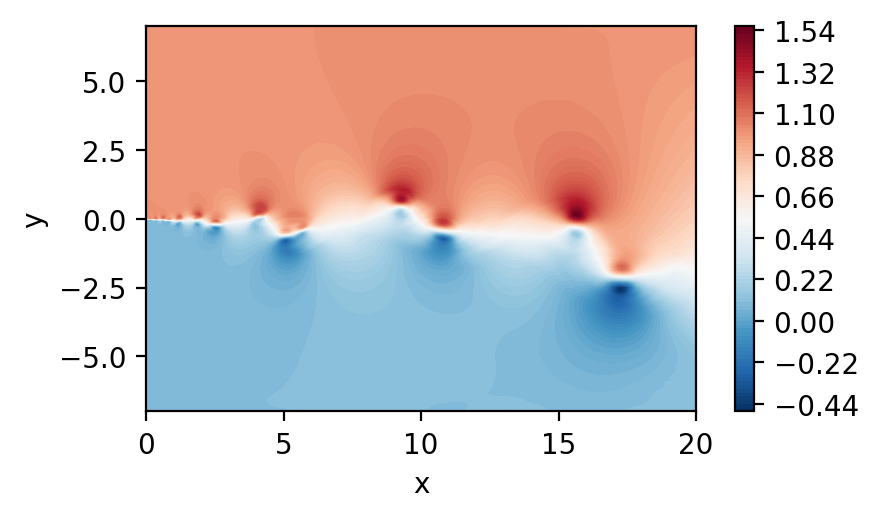

In [4]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Extrude the mesh to be one element deep

For this we can simply use a helper function

In [5]:
# Import helper function
from pysemtools.datatypes.utils import extrude_2d_sem_mesh

# Extrude the 2D mesh to 3D
msh3d, fld3d = extrude_2d_sem_mesh(comm, lz = msh.lx, msh = msh, fld = fld)

2025-04-04 11:35:49,446 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-04-04 11:35:49,448 - Mesh - INFO - Initializing common attributes.
2025-04-04 11:35:49,448 - Mesh - INFO - Getting vertices
2025-04-04 11:35:49,449 - Mesh - INFO - Getting edge centers
2025-04-04 11:35:49,480 - Mesh - INFO - Getting facet centers
2025-04-04 11:35:49,502 - Mesh - INFO - Creating connectivity
2025-04-04 11:35:50,847 - Mesh - INFO - Mesh object initialized.
2025-04-04 11:35:50,847 - Mesh - INFO - Mesh data is of type: float64
2025-04-04 11:35:50,848 - Mesh - INFO - Elapsed time: 1.402246764s
2025-04-04 11:35:50,849 - Field - INFO - Initializing empty Field object


### Mirror the coordinate of interest

Simply multiply the axis to flip by -1

In [6]:
# Mirrored mesh
import copy

y_mirror = msh.y.copy() * -1
# Create the interpolation points
xyz = [msh.x.flatten(), y_mirror.flatten(), msh.z.flatten()]
xyz = np.array(xyz).T
print(xyz.shape)

(102400, 3)


## Interpolate

From here on, the process is the same

### Find the points

The points are always found at the initialization stage. This might be time consiming

In [7]:
# Interpolate the interpolation module
from pysemtools.interpolation.probes import Probes

probes = Probes(comm, probes = xyz, msh = msh3d, point_interpolator_type='multiple_point_legendre_numpy', max_pts=256, find_points_comm_pattern='point_to_point')

2025-04-04 11:35:50,909 - Probes - INFO - Initializing Probes object:
2025-04-04 11:35:50,910 - Probes - INFO -  ======= Settings =======
2025-04-04 11:35:50,910 - Probes - INFO - output_fname: ./interpolated_fields.csv
2025-04-04 11:35:50,911 - Probes - INFO - write_coords: True
2025-04-04 11:35:50,912 - Probes - INFO - progress_bar: False
2025-04-04 11:35:50,913 - Probes - INFO - point_interpolator_type: multiple_point_legendre_numpy
2025-04-04 11:35:50,914 - Probes - INFO - max_pts: 256
2025-04-04 11:35:50,915 - Probes - INFO - find_points_iterative: [False, 5000]
2025-04-04 11:35:50,915 - Probes - INFO - find_points_comm_pattern: point_to_point
2025-04-04 11:35:50,916 - Probes - INFO - elem_percent_expansion: 0.01
2025-04-04 11:35:50,917 - Probes - INFO - global_tree_type: rank_bbox
2025-04-04 11:35:50,917 - Probes - INFO - global_tree_nbins: 1024
2025-04-04 11:35:50,918 - Probes - INFO - use_autograd: False
2025-04-04 11:35:50,918 - Probes - INFO - find_points_tol: 2.2204460492503

### Interpolate

After the points are found, any field can be interpolated

In [8]:
# Interpolate from a field list
probes.interpolate_from_field_list(0, [fld3d.registry['u']], comm, write_data=False)

2025-04-04 11:36:23,097 - Probes - INFO - Interpolating fields from field list
2025-04-04 11:36:23,100 - Probes - INFO - Interpolating field 0
2025-04-04 11:36:23,100 - Interpolator - INFO - Interpolating field from rst coordinates
2025-04-04 11:36:23,729 - Interpolator - INFO - Elapsed time: 0.6277344499999984s


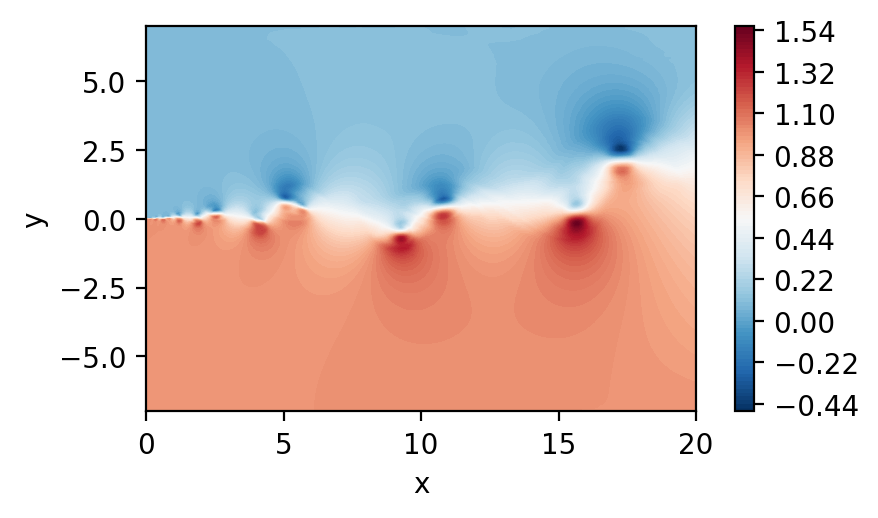

In [13]:
import sys
if comm.Get_rank() == 0:

    u_m = probes.interpolated_fields[:,1]

    fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
    c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,u_m.flatten(), levels=100, cmap="RdBu_r")
    fig.colorbar(c)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

